In [147]:
from torchtext import data, datasets
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer
import re

In [2]:
import os
from typing import Any, Callable, Optional

import nltk
import numpy as np
import pandas as pd
import torch
import torchvision
from PIL import Image
from torchvision.datasets import ImageFolder
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer
from torchtext import data, datasets
from tqdm import tqdm
import random
import string
import re

def preprocess_text(words):
    stop_words = set(stopwords.words('english'))
    stop_words.add('br')
    text = ' '.join(words)
    words = nltk.word_tokenize(text)
    # stemmer = SnowballStemmer("english")
    words = [re.sub('\W+', '', word) for word in words]
    words = [word.lower().replace(' ', '') for word in words if word.lower() not in stop_words]
    # stemmed_words = [stemmer.stem(word) for word in filtered_words]
    return words


class IMDbDatasetSubset(torch.utils.data.Dataset):
    def __init__(self, idxs, max_vocab_size=20000):
        self.TEXT = data.Field(tokenize='spacy', include_lengths=True)
        self.LABEL = data.LabelField(dtype=torch.float)

        train_data, _ = datasets.IMDB.splits(self.TEXT, self.LABEL)
        self.data = train_data
        print('train data size:', len(self.data))

        new_data = []
        for i in idxs:
            new_data.append(self.data[i])
        self.data.examples = new_data

        self.data = self.preprocess_dataset(self.data)

        self.TEXT.build_vocab(self.data, max_size=max_vocab_size, vectors=f"glove.6B.100d")
        self.LABEL.build_vocab(self.data)

        self.fields = {'text': self.TEXT, 'label': self.LABEL}

    def preprocess_dataset(self, dataset):
        new_data = []
        for example in tqdm(dataset.examples, desc="Preprocessing text"):
            text = preprocess_text(example.text)
            label = example.label
            new_example = data.Example.fromlist(
                [text, label], [('text', self.TEXT), ('label', self.LABEL)]
            )
            new_data.append(new_example)
        dataset.examples = new_data
        return dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, split='train', max_vocab_size=20000, embedding_dim=100):

        self.TEXT = data.Field(tokenize='spacy', include_lengths=True)
        self.LABEL = data.LabelField(dtype=torch.float)

        train_data, test_data = datasets.IMDB.splits(self.TEXT, self.LABEL)

        self.TEXT.build_vocab(train_data, max_size=max_vocab_size, vectors=f"glove.6B.{embedding_dim}d")
        self.LABEL.build_vocab(train_data)

        if split == 'train':
            train_data = self.preprocess_dataset(train_data)
            self.data = train_data
        elif split == 'test':
            test_data = self.preprocess_dataset(test_data)
            self.data = test_data
        else:
            raise ValueError("Invalid split. Use 'train', or 'test'.")

        self.fields = {'text': self.TEXT, 'label': self.LABEL}

    def preprocess_dataset(self, dataset):
        new_data = []
        for example in tqdm(dataset.examples, desc="Preprocessing text"):
            text = preprocess_text(example.text)
            label = example.label
            new_example = data.Example.fromlist(
                [text, label], [('text', self.TEXT), ('label', self.LABEL)]
            )
            new_data.append(new_example)
        dataset.examples = new_data
        return dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]
        text = example.text
        label = example.label

        return data.Example.fromlist([text, label], fields=[('text', self.TEXT), ('label', self.LABEL)])


class AugmentedIMDbDataset(IMDbDataset):
    def __init__(self,
                 split='train',
                 max_vocab_size=20000,
                 embedding_dim=100,
                 augment_function=None,
                 num_positive=2,
                 indices=None
                 ):
        super().__init__(split, max_vocab_size, embedding_dim)
        self.num_positive = num_positive
        self.augment_function = augment_function

        augmented_examples = []
        for idx, example in enumerate(self.data.examples):
            if indices is not None and idx not in indices:
                continue
            for _ in range(self.num_positive):
                example_augmented_text = self.augment_function(example.text)
                new_example = data.Example.fromlist(
                    [example_augmented_text, example.label],
                    [('text', self.TEXT), ('label', self.LABEL)]
                )
                augmented_examples.append(new_example)

        # self.TEXT.build_vocab(self.data, max_size=max_vocab_size, vectors=f"glove.6B.{embedding_dim}d")
        # self.LABEL.build_vocab(self.data)

        self.data.examples = augmented_examples

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return super().__getitem__(idx)


In [3]:
from torchtext import data
import torch


class IMDbDataLoader:
    def __init__(self, dataset, batch_size=64, pin_memory=True):
        self.batch_size = batch_size
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Create BucketIterator with the correct sort_key
        self.iterator = data.BucketIterator(
            dataset=dataset,
            batch_size=self.batch_size,
            sort_key=lambda x: len(x.text),  # Add sort_key here
            sort_within_batch=True,
            device=self.device
        )

    def __iter__(self):
        return iter(self.iterator)

    def __len__(self):
        return len(self.iterator)


In [4]:
from data_proc.text_augmentation import *

In [5]:
AUG_FUNC = random_window_selection
imdb_train_dataset = AugmentedIMDbDataset(split='train', augment_function=AUG_FUNC)
train_loader = IMDbDataLoader(imdb_train_dataset)
for x in train_loader:
    text, text_len = x.text
    print(text.shape)
    print(text_len.shape)
    print(x.label.shape)
    break

Preprocessing text: 100%|████████████████| 25000/25000 [00:27<00:00, 903.83it/s]


torch.Size([1485, 64])
torch.Size([64])
torch.Size([64])


In [21]:
imdb_train_dataset = IMDbDataset(split='train')
raw_train_loader = IMDbDataLoader(imdb_train_dataset)
for x in raw_train_loader:
    text, text_len = x.text
    print(text.shape)
    print(text_len.shape)
    print(x.label.shape)
    break

Preprocessing text: 100%|████████████████| 25000/25000 [00:44<00:00, 566.42it/s]


torch.Size([107, 64])
torch.Size([64])
torch.Size([64])


In [6]:
NET_PATH = "2023-12-0518:04:44.496419-imdb-LSTM-99-net.pt"
net = torch.load(NET_PATH)

In [32]:
Z = []
y = []
with torch.no_grad():
    for inputs in tqdm(train_loader):
        text, text_lengths = inputs.text
        z = net(text, text_lengths).detach().cpu()
        Z.append(z)
        y.append(inputs.label.detach().cpu()))
Z = torch.cat(Z, dim=0)
y = torch.cat(y, dim=0)

  0%|          | 0/782 [00:00<?, ?it/s]

In [113]:
N = 1500

X = Z[500:N].numpy()
labels = y[500:N].numpy()

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(X)

In [114]:
import pickle

In [180]:
with open("IMDb-0.4-sas-bert-indices.pkl", "rb") as f:
    subset_indices = pickle.load(f)
    
subset_indices = np.array(subset_indices)

In [181]:
selected = subset_indices[subset_indices < N]

In [186]:
emo_indices = np.array([i for i, l in enumerate(labels) if l == 0])
selected_indices = np.array(['Selected' if i in selected else 'Not selected' for i in range(N)])

In [187]:
pos_data = tsne_results[emo_indices]
pos_selected_indices = selected_indices[emo_indices]

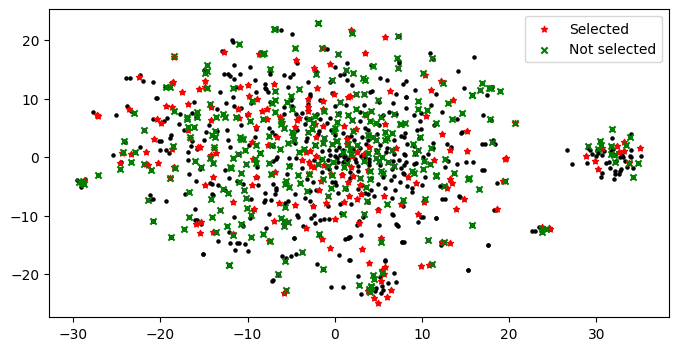

In [188]:
plt.figure(figsize=(8, 4))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], color='black', s=5)

d = pos_data['Selected' == pos_selected_indices]
plt.scatter(d[:, 0], d[:, 1], color='red', marker='*', label='Selected', s=20)

d = pos_data['Not selected' == pos_selected_indices]
plt.scatter(d[:, 0], d[:, 1], color='green', marker='x', label='Not selected', s=20)

plt.legend()
plt.show()

In [18]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_dim, embedding_dim=128, hidden_dim=256, pre_embedding=None, output_dim=None):

        super().__init__()

        self.embedding = nn.Embedding(input_dim, embedding_dim)

        if pre_embedding is not None:
            self.embedding.weight.data.copy_(pre_embedding)

        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=2)

        self.representation_dim = hidden_dim

        if output_dim is not None:
            self.fc = nn.Linear(hidden_dim, output_dim)
        else:
            self.fc = None

    def forward(self, text, text_length):

        # [sentence len, batch size] => [sentence len, batch size, embedding size]
        embedded = self.embedding(text)

        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, text_length.cpu()).cuda()

        # [sentence len, batch size, embedding size] =>
        #  output: [sentence len, batch size, hidden size]
        #  hidden: [1, batch size, hidden size]
        packed_output, (hidden, cell) = self.rnn(packed)

        if self.fc is not None:
            return self.fc(hidden.squeeze(0)).view(-1)
        else:
            return hidden[-1]


tensor([[ 5704,     0,  1917,  ...,    24,   426,  7467],
        [    0,     0,   141,  ...,     0, 10447,     0],
        [  455,  4875,  1525,  ...,     0,     0,  2339],
        ...,
        [  399,   430,   143,  ...,     0,  2330,  1180],
        [    0,   130,     0,  ...,    24,     0,    60],
        [ 1337,     0,   141,  ...,   387,   641,   978]], device='cuda:0')

## CLIP APPROX

In [27]:
from torchtext.vocab import GloVe

In [28]:
class IMDbGloveEmbeddedDataset(torch.utils.data.Dataset):
    def __init__(self, split='train', max_vocab_size=20000, embedding_dim=100):

        RANDOM_SEED = 0

        self.TEXT = data.Field(tokenize='spacy', include_lengths=True)
        self.LABEL = data.LabelField(dtype=torch.float)

        train_data, test_data = datasets.IMDB.splits(self.TEXT, self.LABEL)
        train_data, valid_data = train_data.split(random_state=random.seed(RANDOM_SEED), 
                                                  split_ratio=0.8)

        self.TEXT.build_vocab(train_data, max_size=max_vocab_size, vectors=f"glove.6B.{embedding_dim}d")
        self.LABEL.build_vocab(train_data)

        if split == 'train':
            self.data = train_data
        elif split == 'valid':
            self.data = valid_data
        elif split == 'test':
            self.data = test_data
        else:
            raise ValueError("Invalid split. Use 'train', 'valid', or 'test'.")

        glove = GloVe(name='6B', dim=embedding_dim)
        
        texts = []
        labels = []
        
        for sample in self.data:
            text = sample.text
            label = (1 if sample.label == 'pos' else 0)
            
            word_vectors = [glove[word.lower()] for word in text if word.lower() in glove.stoi]
            texts.append(torch.stack(word_vectors).mean(0))
            labels.append(label)
        self.X = torch.stack(texts)
        self.y = torch.Tensor(labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return (self.X[idx], self.y[idx])

In [30]:
from torch.utils.data import DataLoader

In [31]:
GloveEmbeddedDataset = IMDbGloveEmbeddedDataset('train')

In [32]:
dl = DataLoader(GloveEmbeddedDataset, batch_size=64)

In [40]:
for x in dl:
    print(x[0].shape)
    print(x[1].shape)
    break

torch.Size([64, 100])
torch.Size([64])


In [90]:
from typing import List

In [120]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

In [128]:
from torchtext import datasets

In [150]:
text = train_imdb[0].text
text = ' '.join(text)

In [151]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')



In [161]:
len(train_imdb[0].text)

151

In [152]:
encoded_input = tokenizer(text, return_tensors='pt')
with torch.no_grad():
    outputs = model(**encoded_input)
last_hidden_states = outputs.last_hidden_state

In [165]:
trainset = IMDbDataset('train')


Preprocessing text:   0%|          | 0/25000 [00:00<?, ?it/s]

In [168]:
device = torch.device('cuda')

In [176]:
Z = encode_using_bert(trainset, device)

  0%|          | 0/25000 [00:00<?, ?it/s]

In [179]:
torch.save(Z, 'imdb_trainset_bert_embedding.pt')

In [174]:
def encode_using_bert(dataset, device):

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    texts = []
    
    for i in tqdm(range(len(dataset))):
        sample = dataset[i]
        text = ' '.join(sample.text)
        encoded_input = tokenizer(text, truncation=True, max_length=512, return_tensors='pt')
        with torch.no_grad():
            outputs = model(**encoded_input)
        last_hidden_states = outputs.last_hidden_state
        sentence_vec = last_hidden_states.mean(dim=1)
        
        texts.append(sentence_vec)
        
    Z = torch.cat(texts, dim=0).to(device)
    return Z

In [175]:
self.tokenizer.encode_plus(text, 
                           add_special_tokens=True,  
                           return_token_type_ids=False,
                           truncation=True, 
                           return_attention_mask=True)

NameError: name 'self' is not defined

In [92]:
def encode_using_glove(dataset, device):
    glove = GloVe(name='6B', dim=100)
    texts = []
    
    for i in range(len(dataset)):
        sample = dataset[i]
        word_vectors = [glove[word.lower()] for word in sample.text if word.lower() in glove.stoi]
        texts.append(torch.stack(word_vectors).mean(0))
        
    Z = torch.stack(texts).to(device)
    return Z

In [67]:
def train_linear_classifier(
    X: torch.tensor, 
    y: torch.tensor, 
    representation_dim: int,
    num_classes: int,
    device: torch.device,
    reg_weight: float = 1e-3,
    n_lbfgs_steps: int = 500,
    verbose=False,
):
    if verbose:
        print('\nL2 Regularization weight: %g' % reg_weight)

    criterion = nn.CrossEntropyLoss()
    X_gpu = X.to(device)
    y_gpu = y.to(device)

    # Should be reset after each epoch for a completely independent evaluation
    clf = nn.Linear(representation_dim, num_classes).to(device)
    clf_optimizer = optim.LBFGS(clf.parameters())
    clf.train()

    for _ in tqdm(range(n_lbfgs_steps), desc="Training linear classifier using fraction of labels", disable=not verbose):
        def closure():
            clf_optimizer.zero_grad()
            raw_scores = clf(X_gpu)
            loss = criterion(raw_scores, y_gpu)
            loss += reg_weight * clf.weight.pow(2).sum()
            loss.backward()
            return loss
        clf_optimizer.step(closure)
    return clf

In [77]:
def partition_from_preds(preds):
    partition = {}
    for i, pred in enumerate(preds):
        if pred not in partition:
            partition[pred] = []
        partition[pred].append(i)
    return partition

In [93]:
def glove_approx(
    trainset: torch.utils.data.Dataset,
    labeled_example_indices: List[int], 
    labeled_examples_labels: np.array,
    num_classes: int,
    device: torch.device, 
    batch_size: int = 512,
    verbose: bool = False,
):
    Z = encode_using_glove(trainset, device)
    clf = train_linear_classifier(
        X=Z[labeled_example_indices], 
        y=torch.tensor(labeled_examples_labels), 
        representation_dim=len(Z[0]),
        num_classes=num_classes,
        device=device,
        verbose=False
    )
    preds = []
    for start_idx in range(0, len(Z), batch_size):
        preds.append(torch.argmax(clf(Z[start_idx:start_idx + batch_size]).detach(), dim=1).cpu())
    preds = torch.cat(preds).numpy()

    return partition_from_preds(preds)
    

In [94]:
rand_labeled_examples_indices = random.sample(range(len(imdb_train_dataset)), 500)
rand_labeled_examples_labels = [
    1 if imdb_train_dataset[i].label == 'pos' else 0 for i in rand_labeled_examples_indices
]

In [57]:
imdb_train_dataset = IMDbDataset(split='train')

In [96]:
partition = glove_approx(
    trainset=imdb_train_dataset,
    labeled_example_indices=rand_labeled_examples_indices, 
    labeled_examples_labels=rand_labeled_examples_labels,
    num_classes=2,
    device=device
)

In [26]:
import torch
import torch.nn as nn


class LSTM(nn.Module):
    def __init__(self, input_dim, embedding_dim=128, hidden_dim=256, pre_embedding=None, output_dim=None):

        super().__init__()

        self.embedding = nn.Embedding(input_dim, embedding_dim)

        if pre_embedding is not None:
            self.embedding.weight.data.copy_(pre_embedding)

        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=3)

        self.representation_dim = hidden_dim

        if output_dim is not None:
            self.fc = nn.Linear(hidden_dim, output_dim)
        else:
            self.fc = None

    def forward(self, text, text_length):

        # [sentence len, batch size] => [sentence len, batch size, embedding size]
        embedded = self.embedding(text)

        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, text_length.cpu()).cuda()

        # [sentence len, batch size, embedding size] =>
        #  output: [sentence len, batch size, hidden size]
        #  hidden: [1, batch size, hidden size]
        packed_output, (hidden, cell) = self.rnn(packed)

        if self.fc is not None:
            return self.fc(hidden.squeeze(0)).view(-1)
        else:
            return hidden[-1]


In [19]:
trainset = imdb_train_dataset
net = LSTM(
            input_dim=len(trainset.TEXT.vocab),
            embedding_dim=100,
            pre_embedding=trainset.TEXT.vocab.vectors
        )

In [20]:
device = torch.device('cuda')
net = net.to(device)

In [21]:
text.shape

torch.Size([240, 64])

In [23]:
x = net(text, text_len)

In [25]:
x[-1].shape

torch.Size([64, 256])

## SAS

In [97]:
from abc import ABC
from typing import Dict, List, Optional
import math 
import pickle
import random 

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset

from sas.submodular_maximization import lazy_greedy
from tqdm import tqdm

In [123]:
from torch import nn 

class ProxyModel(nn.Module):
    def __init__(self, net, critic):
        super().__init__()
        self.net = net
        self.critic = critic
    def forward(self, text, text_lengths):
        return self.critic.project(self.net(text, text_lengths))

In [124]:
class BaseSubsetDataset(ABC, Dataset):
    def __init__(
        self,
        dataset: Dataset,
        subset_fraction: float,
        verbose: bool = False
    ):
        """
        :param dataset: Original Dataset
        :type dataset: Dataset
        :param subset_fraction: Fractional size of subset
        :type subset_fraction: float
        :param verbose: verbose
        :type verbose: boolean
        """
        self.dataset = dataset
        self.subset_fraction = subset_fraction
        self.len_dataset = len(self.dataset)
        self.subset_size = int(self.len_dataset * self.subset_fraction)
        self.subset_indices = None
        self.verbose = verbose 

    def initialization_complete(self):
        if self.verbose:
            print(f"Subset Size: {self.subset_size}")
            print(f"Discarded {self.len_dataset - self.subset_size} examples")

    def __len__(self):
        return self.subset_size
    
    def __getitem__(self, index):
        # Get the index for the corresponding item in the original dataset
        original_index = self.subset_indices[index]
        
        # Get the item from the original dataset at the corresponding index
        original_item = self.dataset[original_index]
        
        return original_item
    
    def save_to_file(self, filename):
        with open(filename, "wb") as f:
            pickle.dump(self.subset_indices, f)

In [125]:

from typing import Dict, Optional

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset

from sas.submodular_maximization import lazy_greedy
from sas.subset_dataset import BaseSubsetDataset, SubsetSelectionObjective
from tqdm import tqdm

from data_proc.NLPDataLoader import IMDbDataLoader


class SASSubsetTextDataset(BaseSubsetDataset):
    def __init__(
            self,
            dataset: Dataset,
            subset_fraction: float,
            num_downstream_classes: int,
            device: torch.device,
            approx_latent_class_partition: Dict[int, int],
            proxy_model: Optional[nn.Module] = None,
            augmentation_distance: Optional[Dict[int, np.array]] = None,
            num_runs=1,
            pairwise_distance_block_size: int = 1024,
            threshold: float = 0.0,
            verbose: bool = False
    ):
        """
        dataset: Dataset
            Original dataset for contrastive learning. Assumes that dataset[i] returns a list of augmented views of the original example i.

        subset_fraction: float
            Fractional size of subset.

        num_downstream_classes: int
            Number of downstream classes (can be an estimate).

        proxy_model: nn.Module
            Proxy model to calculate the augmentation distance (and kmeans clustering if the avoid clip option is chosen).

        augmentation_distance: Dict[int, np.array]
            Pass a precomputed dictionary containing augmentation distance for each latent class.

        num_augmentations: int
            Number of augmentations to consider while approximating the augmentation distance.

        pairwise_distance_block_size: int
            Block size for calculating pairwise distance. This is just to optimize GPU usage while calculating pairwise distance and will not affect the subset created in any way.

        verbose: boolean
            Verbosity of the output.
        """
        super().__init__(
            dataset=dataset,
            subset_fraction=subset_fraction,
            verbose=verbose
        )
        self.device = device
        self.num_downstream_classes = num_downstream_classes
        self.proxy_model = proxy_model
        self.partition = approx_latent_class_partition
        self.augmentation_distance = augmentation_distance
        self.num_runs = num_runs
        self.pairwise_distance_block_size = pairwise_distance_block_size

        if self.augmentation_distance is None:
            self.augmentation_distance = self.approximate_augmentation_distance()

        class_wise_idx = {}
        for latent_class in tqdm(self.partition.keys(), desc="Subset Selection:", disable=not verbose):
            F = SubsetSelectionObjective(self.augmentation_distance[latent_class].copy(), threshold=threshold)
            class_wise_idx[latent_class] = lazy_greedy(F, range(len(self.augmentation_distance[latent_class])),
                                                       len(self.augmentation_distance[latent_class]))
            class_wise_idx[latent_class] = [self.partition[latent_class][i] for i in class_wise_idx[latent_class]]

        self.subset_indices = []
        for latent_class in class_wise_idx.keys():
            l = len(class_wise_idx[latent_class])
            self.subset_indices.extend(class_wise_idx[latent_class][:int(self.subset_fraction * l)])

        self.initialization_complete()

    def approximate_augmentation_distance(self):
        self.proxy_model = self.proxy_model.to(self.device)

        # Initialize augmentation distance with all 0s
        augmentation_distance = {}
        Z = self.encode_trainset()
        for latent_class in self.partition.keys():
            Z_partition = Z[self.partition[latent_class]]
            pairwise_distance = SASSubsetTextDataset.pairwise_distance(Z_partition, Z_partition)
            augmentation_distance[latent_class] = pairwise_distance.copy()
        return augmentation_distance

    def encode_trainset(self):
        trainloader = IMDbDataLoader(self.dataset, batch_size=self.pairwise_distance_block_size)

        with torch.no_grad():
            Z = []
            for input in trainloader:
                text, text_lengths = input.text
                Z.append(self.proxy_model(text.to(self.device), text_lengths.to(self.device)))
        return torch.cat(Z, dim=0)

    def encode_augmented_trainset(self, num_positives=1):
        trainloader = IMDbDataLoader(self.dataset, batch_size=self.pairwise_distance_block_size)

        with torch.no_grad():
            Z = []

            for input in trainloader:
                text, text_lengths = input.text
                Z.append(self.proxy_model(text.to(self.device), text_lengths.to(self.device)))
            Z = torch.stack(Z)

            aug_z = []
            idxs = torch.arange(0, len(Z), num_positives)
            for i in range(num_positives):
                aug_z.append(Z[idxs + i])

            Z = torch.cat(aug_z, dim=0)
        return Z

    @staticmethod
    def pairwise_distance(Z1: torch.tensor, Z2: torch.tensor, block_size: int = 1024):
        similarity_matrices = []
        for i in range(Z1.shape[0] // block_size + 1):
            similarity_matrices_i = []
            e = Z1[i * block_size:(i + 1) * block_size]
            for j in range(Z2.shape[0] // block_size + 1):
                e_t = Z2[j * block_size:(j + 1) * block_size].t()
                similarity_matrices_i.append(
                    np.array(
                        torch.cosine_similarity(e[:, :, None], e_t[None, :, :]).detach().cpu()
                    )
                )
            similarity_matrices.append(similarity_matrices_i)
        similarity_matrix = np.block(similarity_matrices)

        return similarity_matrix

In [126]:
import torch 
from sas.subset_dataset import SASSubsetDataset
net = torch.load("2023-12-0317:57:33.875617-imdb-LSTM-99-net.pt")
critic = torch.load("2023-12-0317:57:33.875617-imdb-LSTM-99-critic.pt")
proxy_model = ProxyModel(net, critic)
from data_proc import NLPDataLoader
     
subset_dataset = SASSubsetTextDataset(
    dataset=imdb_train_dataset,
    subset_fraction=0.2,
    num_downstream_classes=2,
    device=device,
    proxy_model=proxy_model,
    approx_latent_class_partition=partition,
    verbose=True
)

Subset Selection:: 100%|██████████████████████████| 2/2 [00:06<00:00,  3.23s/it]

Subset Size: 4000
Discarded 16000 examples


In [128]:
subset_dataset.subset_indices

[8472,
 14893,
 2441,
 9287,
 4128,
 9733,
 6734,
 3756,
 10750,
 5381,
 11370,
 14528,
 5011,
 8044,
 1009,
 6437,
 9895,
 15517,
 3662,
 16773,
 16960,
 19142,
 2366,
 6584,
 612,
 16492,
 2273,
 2153,
 352,
 5307,
 14809,
 5467,
 9310,
 3739,
 19251,
 8382,
 3999,
 14050,
 8120,
 19840,
 2623,
 13325,
 14108,
 13882,
 19774,
 12487,
 3031,
 8783,
 5702,
 18406,
 13661,
 14383,
 3590,
 297,
 8994,
 6536,
 10220,
 6939,
 9346,
 3534,
 18232,
 7234,
 5494,
 8773,
 13392,
 13361,
 9649,
 7227,
 7818,
 7297,
 8396,
 8812,
 13363,
 11936,
 2148,
 14019,
 7158,
 9240,
 16081,
 116,
 6411,
 10525,
 8466,
 2847,
 1672,
 1546,
 9799,
 711,
 11099,
 8751,
 13518,
 8404,
 686,
 19820,
 1357,
 18297,
 4207,
 7207,
 4424,
 15851,
 3086,
 6361,
 12913,
 16329,
 1291,
 443,
 6782,
 18708,
 2682,
 18313,
 3255,
 11058,
 17051,
 17041,
 12497,
 7049,
 1614,
 13943,
 15459,
 19240,
 10506,
 9604,
 5478,
 11688,
 15923,
 15820,
 12976,
 12152,
 16733,
 8320,
 12130,
 17530,
 6470,
 7232,
 18166,
 19813

## TEST on 2 Layer Linear

In [39]:
dataloader = DataLoader(imdb_train_dataset, batch_size=64,
                        shuffle=True, num_workers=2)

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim

In [41]:
class SimpleClassifier(nn.Module):
    def __init__(self, embedding_dim, output_dim):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(embedding_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, embedded):
        x = torch.relu(self.fc1(embedded))
        output = self.fc2(x)
        return output

In [42]:
output_dim = 2  # 二分类问题，输出维度为2
embedding_dim = 100
model = SimpleClassifier(embedding_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [43]:
epochs = 5
for epoch in range(epochs):
    for batch in tqdm(dataloader):
        embedding, labels = batch
        labels = labels.to(torch.long)
        optimizer.zero_grad()
        predictions = model(embedding)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

In [44]:
imdb_test_dataset = IMDbDataset(split='test')

In [45]:
test_loader = DataLoader(imdb_test_dataset, batch_size=64,
                        shuffle=True, num_workers=2)

In [46]:
# 在测试集上评估模型
correct = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        embedding, labels = batch
        labels = labels.to(torch.long)
        predictions = model(embedding)
        _, predicted = torch.max(predictions.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

In [47]:
accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 77.79%


In [124]:
loader = IMDbDataLoader(imdb_train_dataset, batch_size=64)

In [158]:
sentences = []
for i in range(len(imdb_train_dataset)):
    text = imdb_train_dataset.__getitem__(i).text
    word_vectors = [glove[word.lower()] for word in text if word in glove.stoi]
    sentences.append(torch.stack(word_vectors).mean(0))

In [161]:
X.shape

torch.Size([20000, 100])